<a href="https://colab.research.google.com/github/DanielHolzwart/Instruction-based-classification-with-Flan-T5-large-model-qlora/blob/main/Instruction_based_classification_with_Flan_T5_large_model_%2B_qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Install packages

In [1]:
%%capture
#optimum optimize and accelerates the deployment of transformer models
#!pip install optimum
#the model we are going to load (Mistral-7b) is quantized which is why we need the aut-gptq dependency
%pip install auto-gptq
#runs the model with lower precision to save memory
%pip install bitsandbytes

In [2]:
%%capture
%pip install datasets

# 1. Investigating the Datases

## Exploring some numbers


First of all, let us explore the news dataset. It contains 120k training and 12k test news articles with 4 different categories: 'World', 'Sports', 'Business', 'Sci/Tech'. We are only going to load 10% of the dataset.

In [3]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

# Load the ag_news dataset from Hugging Face
news_dataset = load_dataset("ag_news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [4]:
dataset_len_red = int(len(news_dataset['train'])/10) # take 10% of dataset
train_tmp = news_dataset['train'].shuffle(1).select(range(dataset_len_red))
test_tmp = news_dataset['train'].shuffle(1).select(range(int(dataset_len_red/10)))
news_dataset = DatasetDict({'train' : train_tmp, 'test' : test_tmp}) # redefine dataset with fewer samples

In [5]:
from pprint import pprint
pprint(news_dataset['train'][0]) # print first example of dataset

{'label': 1,
 'text': 'Brown feels fortunate to have a hand in series Thirty-two pitches. '
         "That's a couple innings for most pitchers -- or two lengthy Johnny "
         "Damon at-bats. It amounted to Kevin Brown's entire body of work "
         'against the Red Sox Sept. 26. It was not a pretty sight.'}


In [6]:
labels_chr = news_dataset['train'].features['label'].names
labels_num = set(news_dataset['train']['label'])
print(f'Labels of dataset: {labels_chr}')
print(f'with their respective nummerical representation: {labels_num}')

Labels of dataset: ['World', 'Sports', 'Business', 'Sci/Tech']
with their respective nummerical representation: {0, 1, 2, 3}


We will define dictionary id2label and label2id which will give us the 1:1 correspondence between label in their numerical and character levle representation.

In [7]:
id2label = {}
label2id = {}
for id, label in zip(labels_num, labels_chr):
    id2label.update({id : label})
    label2id.update({label : id})

In [8]:
print(label2id)
print(id2label)

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}
{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


## Visualizing the data

Now it is time to visualize the data. This is useful for e.g. ensuring that the data fits into the context window of our transformer model.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
news_train_pd = news_dataset['train'].to_pandas()

The number of words are not 1:1 to the numbers of tokens in the tokenization step but it gives us a good enough approximation.

In [11]:
news_train_pd['number_words'] = news_train_pd['text'].apply(lambda x : len(x.split()))

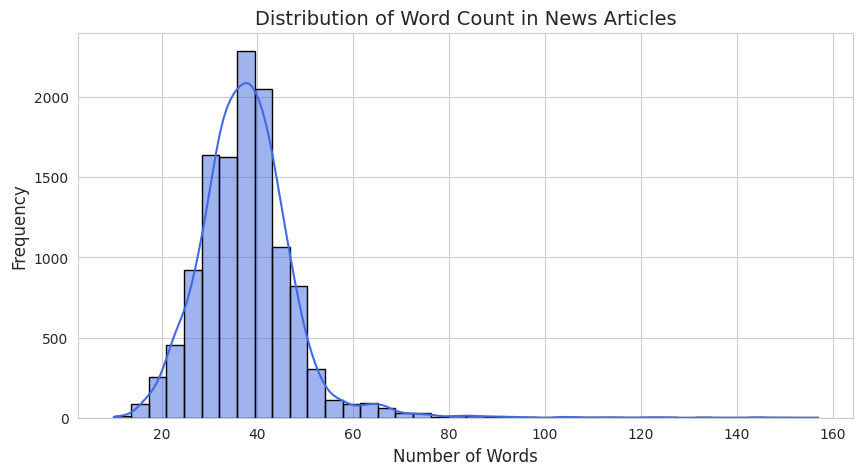

In [12]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 5))
sns.histplot(news_train_pd['number_words'], bins=40, kde=True, color="royalblue", edgecolor="black")

# Add labels and title
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Word Count in News Articles", fontsize=14)

# Improve x-axis readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


With most number of words in the range of 20 - 60 we will not encounter any problems regarding the context window. Next, let us check how balanced our dataset is.

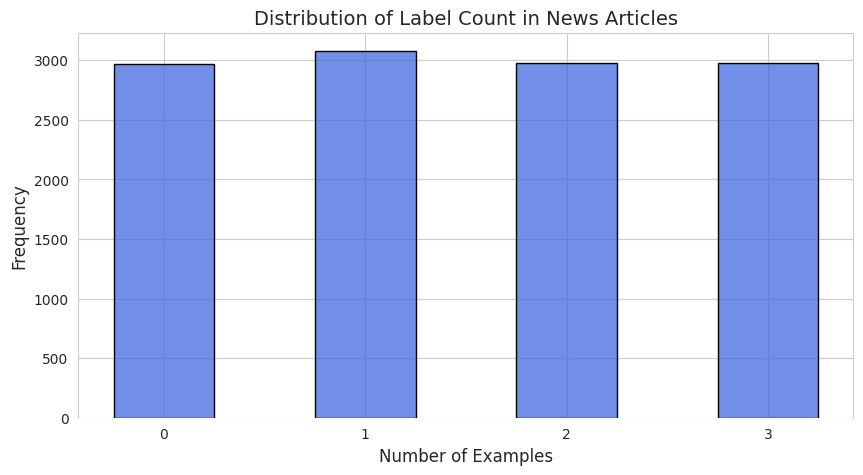

In [13]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 5))
ax = sns.histplot(news_train_pd['label'], bins=4, shrink=0.5, color="royalblue", edgecolor="black")

# Add labels and title
plt.xlabel("Number of Examples", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Label Count in News Articles", fontsize=14)

ax.spines['bottom'].set_visible(False)  # Hide x-axis line
bar_positions = [p.get_x() + p.get_width() / 2 for p in ax.patches]  # Get center of each bar
ax.set_xticks(bar_positions)
ax.set_xticklabels(["0", "1", "2", "3"], fontsize=12, ha='center')

# Improve x-axis readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

The labels looks fairly balanced so we will try to create a model which is correct at least 25% of the time.

# 2. Flant-T5

## Getting the model

The model we will work with is the instruction fine-tuned encoder-decoder transformers Flan-T5 large. As we want to train the model, we will already download a quantized version of it.

In [14]:
from transformers import BitsAndBytesConfig
import torch

In [15]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,  # use float16 for gradients in training
    bnb_4bit_use_double_quant=True, # double quantization to reduce memory even further
    bnb_4bit_quant_type="nf4", # load in nf4
)

In [16]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large",
                                              device_map = 'auto',
                                              torch_dtype = 'auto',
                                              quantization_config = quantization_config)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [17]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

We can double check that quantization procedure worked. Note that some parameters for some layers remain in fp32 format.

In [18]:
for i, (name, param) in enumerate(model.named_parameters()):
    print(f"{name} -> {param.dtype}")
    if i == 2:
        break

shared.weight -> torch.float32
encoder.block.0.layer.0.SelfAttention.q.weight -> torch.uint8
encoder.block.0.layer.0.SelfAttention.k.weight -> torch.uint8


We further define a function which can check the number of trainable parameters of our. After applying lora, we will see that the number of trainable parameters will be just about 1% of the original model.

In [19]:
def trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

trainable_parameters_orig = trainable_parameters(model)
print(f"Trainable Parameters: {trainable_parameters_orig:,}")

Trainable Parameters: 204,336,128


## Tokenizing the dataset for zero shot

In [20]:
prompt_zero_shot = """
    Classify the following news article into one of these four categories: [World, Sports, Business, Sci/Tech].

    Return only the category name.

    Article:
    {text}
    """

In [21]:
def add_prompt_to_article(batch):
    return {'text_zero_shot' : [prompt_zero_shot.format(text=article) for article in batch["text"]]}

news_dataset_zero_shot = news_dataset.map(add_prompt_to_article,  batched = True)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Now we are ready to tokenize the dataset

In [22]:
def tokenize(example):
    text = example['text_zero_shot']
    tokenized_inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding = True)
    return tokenized_inputs

In [23]:
news_dataset_zero_shot_encoded = news_dataset_zero_shot.map(tokenize, batched = True)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Notice that column 'text' contains the original article while 'input_ids' are the tokenized zero shot articles, which are called 'text_zero_shot'

In [24]:
news_dataset_zero_shot_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_zero_shot', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label', 'text_zero_shot', 'input_ids', 'attention_mask'],
        num_rows: 1200
    })
})

In [25]:
news_dataset_zero_shot_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Before we do any fine-tuning, let us first vanilla check whether our model already gives us the desired results.

## Zero shot inference

In [26]:
news_dataset_zs_test = news_dataset_zero_shot_encoded['test'].select(range(15)) # define a test dataset containing 15 examples

Let us now check how our model performs with zero shot learning. We will need to define a prompt generation config which enables us to further restrict the amounts of tokens generated. Let us check which amount this should be:

In [27]:
lengths = []
for classes in labels_chr:
    ids = tokenizer(classes).input_ids
    tokens = tokenizer.convert_ids_to_tokens(ids)
    lengths.append(len(tokens))
    print(tokens)

print(f"\nMaximum number of tokens within all classes: {max(lengths)}")

['▁World', '</s>']
['▁Sports', '</s>']
['▁Business', '</s>']
['▁Sci', '/', 'Tech', '</s>']

Maximum number of tokens within all classes: 4


In particular, we see that the max length, without the special token, is 3.

In [28]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    max_new_tokens=3,  # Allow 3 tokens for class label
    do_sample=False    # Use greedy decoding, no sampling
)

In [29]:
for example in news_dataset_zs_test:
    input = {'input_ids' : example['input_ids'].unsqueeze(0).to(device), 'attention_mask' : example['attention_mask'].unsqueeze(0).to(device)}
    output = model.generate(**input, generation_config=generation_config)
    break

In [30]:
model.eval() # put model into evaluation mode to disable dropout layers
rows = []
with torch.no_grad():
    for example in news_dataset_zs_test:
        label = example['label']
        input = {'input_ids' : example['input_ids'].unsqueeze(0).to(device), 'attention_mask' : example['attention_mask'].unsqueeze(0).to(device)}
        output = model.generate(**input, generation_config=generation_config)
        prediction = tokenizer.batch_decode(output, skip_special_tokens=True)
        rows.append({'Model' : prediction[0], 'Label' : id2label[label.item()]})

pd.DataFrame(rows)

,Model,Label
0,Sports,Sports
1,World,World
2,Business,Business
3,Sports,Sports
4,Sports,Sports
5,Sci/Tech,Business
6,Sports,Sports
7,Sci/Tech,Sci/Tech
8,Business,Business
9,Sci/Tech,Sci/Tech


This worked suprisingly well. We need to test it zero shot learning within a bigger context by using the whole test set and define a appropiate evluation function.

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.grid(False)
    plt.show()

Define a forward_pass function which gives us the prediction of the whole test set.

In [32]:
def forward_pass(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model.generate(**inputs, generation_config=generation_config)
        prediction = tokenizer.batch_decode(output, skip_special_tokens=True)
    return {"prediction": prediction, "prediction_id" : [label2id[x] for x in prediction]}

In [33]:
news_dataset_zero_shot_conf = news_dataset_zero_shot_encoded['test'].map(forward_pass, batched = True, batch_size = 100)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

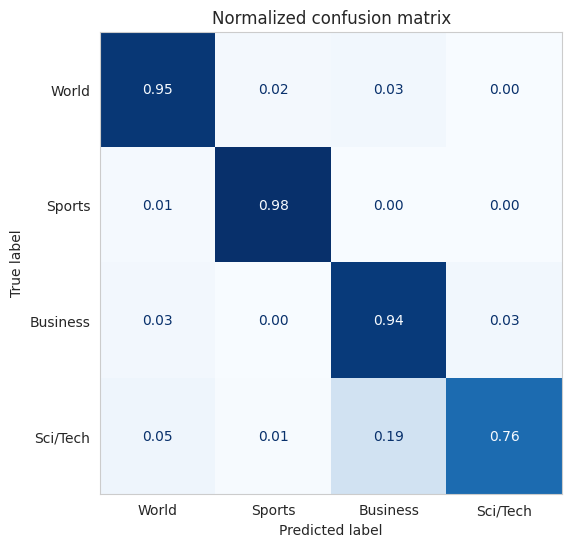

In [34]:
y_pred = news_dataset_zero_shot_conf['prediction_id']
y_true = news_dataset_zero_shot_conf['label']
plot_confusion_matrix(y_pred, y_true, labels_chr)

Looking at the confusion matrix, we see that our zero shot approach yields quite decent results. Let us check whether we can archieve something with few shot learning.

## 2-shot inference

We could give the model one example of each category with the respective label so it better understands how we want to classify news articles. But the problems of this approach is that the context window of Flan-T5, being 512, is too small. Hence, looking at the zero shot result, it looks like somethimes Sci/Tech is mixed up with business. Therefore, we will 2-shot prompt with business and sci/tech examples. Afterwards, we will plot the confusion matrix as above.

In [82]:
# get one example text for both sci/tech and business

label_check = []
texts = []
for label, text in zip(news_dataset['train']['label'], news_dataset['train']['text']): # loop through dataset to find examples
    if label in [2,3]:
        texts.append(text)
        label_check.append(label)
    if len(label_check) == 2: # break condition if we have two examples
        break

In [84]:
texts

['Sprint and RadioShack enter deal to open wireless kiosks in malls RadioShack Corp. (NYSE: RSH), on Tuesday said it has entered into an agreement with Sprint Corp. (NYSE: FON) to open Sprint-branded wireless kiosks in malls nationwide.',
 'ADV: Free Anti-Virus Scan If your computer is slowing down or crashing, you may have a virus. Scan now to find out!  Detects viruses, spyware and worms. Includes free spam and popup blockers.']

In [43]:
labels_chr

['World', 'Sports', 'Business', 'Sci/Tech']

In [168]:
prompt_few_shot = """
    Classify the following news article into one of these four categories: [World, Sports, Business, Sci/Tech].

    Return only the category name. Never write Science/Tech instead of Sci/Tech.

    Here are some examples:

    Article: {business}
    Category: Business

    Article: {sci}
    Category: Sci/Tech

    Now, classify the following article:

    Article:
    {text}

    Return only the category name exactly as written in the list above.
    """

We just need to be cautious as the context window of Flan-T5 is 512, so we need to check the words lengths. First, we are going to add the prompts to the new arcticles.

In [162]:
def add_prompt_to_article(batch):
    return {'text_few_shot' : [prompt_few_shot.format(text=article, business = texts[0], sci = texts[1]) for article in batch["text"]]}

news_dataset_few_shot = news_dataset.map(add_prompt_to_article,  batched = True)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Let us check the word count wich is roughly equal to the token count.

In [163]:
lengths = [len(x.split()) for x in news_dataset_few_shot['test']['text_few_shot']]

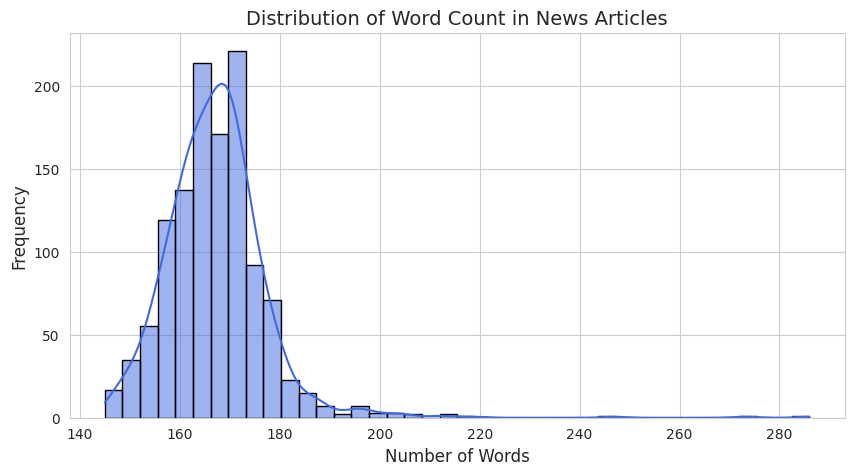

In [164]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=40, kde=True, color="royalblue", edgecolor="black")

# Add labels and title
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Word Count in News Articles", fontsize=14)

# Improve x-axis readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

It looks like the context size is not going to cause any troubles.

In [165]:
def tokenize(example):
    text = example['text_few_shot']
    tokenized_inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding = True)
    return tokenized_inputs

news_dataset_few_shot_encoded = news_dataset_few_shot.map(tokenize, batched = True)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [166]:
news_dataset_few_shot_encoded.set_format('torch', columns = ['input_ids','attention_mask', 'label'])

We need to define anoher forward pass function, as our model sometimes write Science/Tech instead of Sci/Tech. We will do the correct mapping afterwards.

In [171]:
def forward_pass(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model.generate(**inputs, generation_config=generation_config)
        prediction = tokenizer.batch_decode(output, skip_special_tokens=True)
    return {"prediction": prediction}

In [172]:
news_dataset_few_shot_conf = news_dataset_few_shot_encoded['test'].map(forward_pass, batched = True, batch_size = 100)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [176]:
news_dataset_pred = []
for pred in news_dataset_few_shot_conf['prediction']:
    if pred == 'Science/Tech':
        news_dataset_pred.append('Sci/Tech')
    else:
        news_dataset_pred.append(pred)

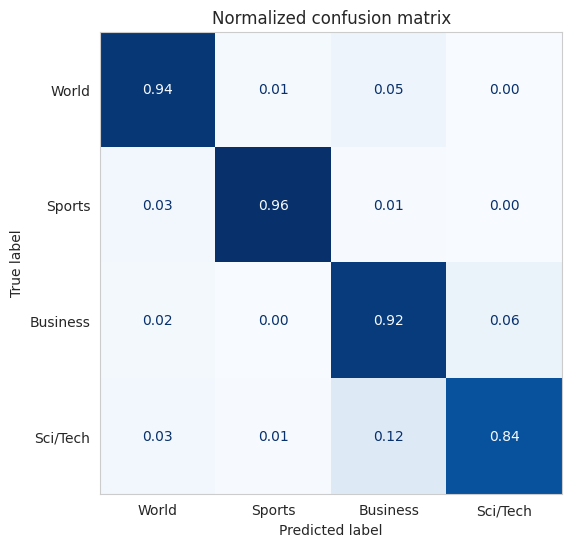

In [177]:
y_pred = [label2id[x] for x in news_dataset_pred]
y_true = news_dataset_zero_shot_conf['label']
plot_confusion_matrix(y_pred, y_true, labels_chr)

# Training

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_bert)

In [ ]:
import torch

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
%pip uninstall wandb -y
import os
os.environ["WANDB_MODE"] = "disabled"

Found existing installation: wandb 0.19.6
Uninstalling wandb-0.19.6:
  Successfully uninstalled wandb-0.19.6


In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
# hyperparameters
lr = 2e-5
batch_size = 32
logging_steps = len(news_dataset_encoded["train"]) // batch_size
num_epochs = 1

# define training arguments
training_args = TrainingArguments(
    output_dir= "distilbert-base-uncased" + "-cpu-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False
)

In [ ]:
#trainer = Trainer(model=model_bert,
#                 args=training_args,
#                 compute_metrics=compute_metrics,
#                 train_dataset=news_dataset_encoded["train"],
#                 eval_dataset=news_dataset_encoded["test"],
#                 tokenizer=tokenizer_bert
#                 )
#trainer.train();

In [ ]:
#preds_output = trainer.predict(news_dataset_encoded['test'])

In [ ]:
#y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds, normalize="true")
#     fig, ax = plt.subplots(figsize=(6, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
#     plt.title("Normalized confusion matrix")
#     plt.show()

In [ ]:
#plot_confusion_matrix(y_preds, news_dataset_encoded['test']['labels'].numpy(), news_dataset['train'].features['label'].names)

In [ ]:
#pip uninstall optimum auto-gptq bitsandbytes

In [ ]:
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig

In [ ]:
# peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
#                         r=4, # intrinsic rank of trainable weight matrix
#                         lora_alpha=32, # this is like a learning rate
#                         lora_dropout=0.01, # probablity of dropout
#                         target_modules = ['q_lin']) # we apply lora to query layer only

In [ ]:
# model_lora = get_peft_model(model_bert, peft_config)
# model_lora.print_trainable_parameters()

In [ ]:
# trainer = Trainer(model=model_lora,
#                   args=training_args,
#                   compute_metrics=compute_metrics,
#                   train_dataset=news_dataset_encoded["train"],
#                   eval_dataset=news_dataset_encoded["test"],
#                   tokenizer=tokenizer_bert
#                   )
# trainer.train();

In [ ]:
training_args = TrainingArguments(
    output_dir= "distilbert-base-uncased" + "-cpu-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    fp16=True,
    optim="paged_adamw_8bit"
)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define 4-bit quantization settings (only for CUDA)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Disable on CPU
    bnb_4bit_compute_dtype=torch.float16,  # Use float32 for gradients
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    llm_int8_skip_modules=["classifier", "pre_classifier"]
)

# Load model (quantized on CUDA, vanilla on CPU)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4,
    quantization_config=quantization_config
)

# Prepare model for training (critical for quantized models)
model = prepare_model_for_kbit_training(model)

# Move to device AFTER preparation
model.to(device)

# Define QLoRA settings (expand target_modules)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],  # Target all query/value layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

for name, param in model.named_parameters():
    # Freeze everything that is not part of the LoRA adapters
    if "lora" not in name:
        param.requires_grad = False

# Apply QLoRA
model = get_peft_model(model, lora_config)

# Verify trainable parameters
model.print_trainable_parameters()


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 888,580 || all params: 67,845,128 || trainable%: 1.3097


In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=news_dataset_encoded["train"],
                  eval_dataset=news_dataset_encoded["test"],
                  tokenizer=tokenizer_bert
                  )
trainer.train();

<ipython-input-56-99a2e98d3d00>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.303795,0.901316,0.901099
2,0.635800,0.269596,0.901316,0.900910
3,0.318200,0.261506,0.906579,0.906292


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

In [ ]:
preds_output = trainer.predict(news_dataset_encoded['test'])
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

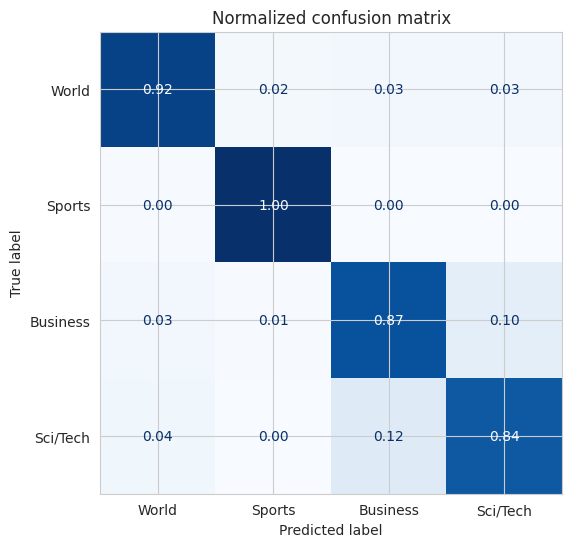

In [ ]:
plot_confusion_matrix(y_preds, news_dataset_encoded['test']['labels'], news_dataset_encoded['test'].features['labels'].names)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
inputs = tokenizer("How can i get big and strong?", return_tensors = 'pt')
outputs = model.generate(input_ids = inputs.input_ids, max_new_tokens=100, top_k = 50, top_p = 0.95, do_sample = True)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How can i get big and strong?
You want big and strong muscles. How will you develop your muscles? With hard, heavy weight lifting. To do heavy lifting you have to train consistently with a lot of effort. I'm talking about two to four hours a day, five days a week. If you have not trained consistently for five years you will probably look just like you did when you were in high school.
You want to be healthy. How will you stay healthy? By doing the best you can. If you do


In [ ]:
from torch.quantization import quantize_dynamic

In [ ]:
import torch.nn as nn

In [ ]:
%%capture
!pip install bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_quant = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",
                                             quantization_config=quantization_config,
                                             device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct")

In [ ]:
test = tokenizer(testt, return_tensors='pt')
test = {k:v.to('cuda') for k, v in test.items()}
tokenizer.batch_decode(model.generate(**test), skip_special_tokens= True)

['Sports']

In [ ]:
testt = """Classify the following news article into one of these four categories: [World, Sports, Business, Sci/Tech].

    Return only the category name.

    Article:
    Brown feels fortunate to have a hand in series Thirty-two pitches. That's a couple innings for most pitchers -- or two lengthy Johnny Damon at-bats. It amounted to Kevin Brown's entire body of work against the Red Sox Sept. 26. It was not a pretty sight"""


In [ ]:
model.eval() # put model into evaluation mode to disable dropout layers
for example in news_dataset_few:
    article = example['text']
    prompt = prompt_zero_shot.format(text = article)
    print()


    Classify the following news article into one of these four categories: [World, Sports, Business, Sci/Tech].

    Return only the category name.

    Article:
    Brown feels fortunate to have a hand in series Thirty-two pitches. That's a couple innings for most pitchers -- or two lengthy Johnny Damon at-bats. It amounted to Kevin Brown's entire body of work against the Red Sox Sept. 26. It was not a pretty sight.
    


# ---------- Embedding Test -----------

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
model.to('cuda')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
from pprint import pprint
pprint(news_dataset['train']['text'][0])

("Brown feels fortunate to have a hand in series Thirty-two pitches. That's a "
 'couple innings for most pitchers -- or two lengthy Johnny Damon at-bats. It '
 "amounted to Kevin Brown's entire body of work against the Red Sox Sept. 26. "
 'It was not a pretty sight.')


In [ ]:
def embed(batch):
    embeddings = model.encode(batch['text'], device = 'cuda')
    return {'embeddings' : embeddings}

In [ ]:
news_dataset_train_embedded = news_dataset['train'].map(embed, batched = True)
news_dataset_test_embedded = news_dataset['test'].map(embed, batched = True)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train = news_dataset_train_embedded['embeddings']
y_train = news_dataset_train_embedded['label']

In [ ]:
clf = LogisticRegression(random_state = 1)
clf.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [ ]:
y_pred = clf.predict(news_dataset_test_embedded['embeddings'])
y_true = news_dataset_test_embedded['label']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def report(y_pred, y_true, names):
    cm = confusion_matrix(y_true, y_pred, normalize = "true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = names)
    disp.plot(cmap="Blues", values_format=".2f", colorbar = False)  # Use a nice colormap
    plt.grid(False)
    plt.show()


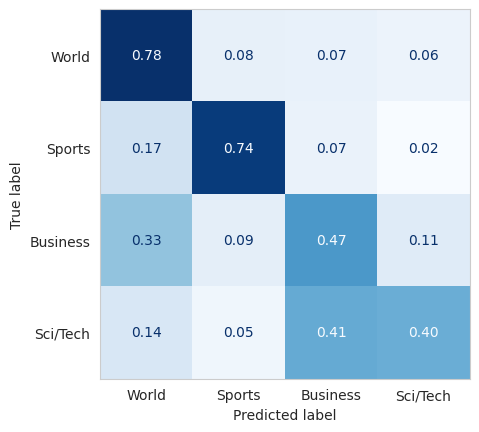

In [ ]:
report(y_pred, y_true, names)

One shot test

In [ ]:
# get one example text per label

labels = [0,1,2,3]
label_check = []
texts = []
for label, text in zip(news_dataset_train_embedded['label'], news_dataset_train_embedded['text']):
    if label not in label_check:
        texts.append(text)
        label_check.append(label)
    if len(label_check) == 4:
        break

In [ ]:
# Ensure ordered texts [0 → 1 → 2 → 3], important for cosine similarity
texts = [texts[label] for label in label_check]

In [ ]:
texts

['Security Council agrees on Sudan resolution as foes pledge &lt;b&gt;...&lt;/b&gt; NAIROBI (AFP) - UN ambassadors agreed here unanimously on the text of a resolution aimed at restoring peace to war-ravaged Sudan, as the country #39;s main foes promised to conclude talks on their 21-year-old conflict by the end of the year.',
 "Brown feels fortunate to have a hand in series Thirty-two pitches. That's a couple innings for most pitchers -- or two lengthy Johnny Damon at-bats. It amounted to Kevin Brown's entire body of work against the Red Sox Sept. 26. It was not a pretty sight.",
 'Sprint and RadioShack enter deal to open wireless kiosks in malls RadioShack Corp. (NYSE: RSH), on Tuesday said it has entered into an agreement with Sprint Corp. (NYSE: FON) to open Sprint-branded wireless kiosks in malls nationwide.',
 'Nokia lets parents filter out mobile smut Phone maker debuts software that gives parents more control over content that children access on cellular devices.']

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sim_matrix = cosine_similarity(news_dataset_test_embedded['embeddings'], model.encode(texts))
y_pred = np.argmax(sim_matrix, axis = 1)

In [ ]:
labels_chr

['World', 'Sports', 'Business', 'Sci/Tech']

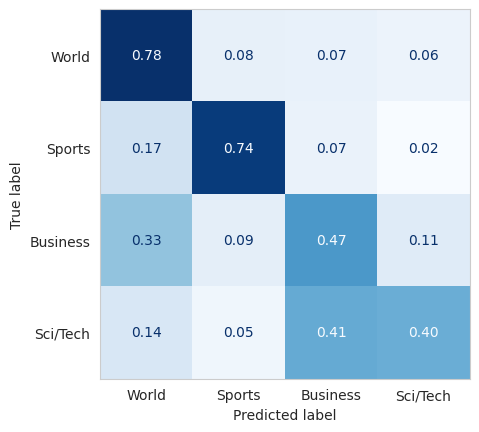

In [ ]:
report(y_pred, y_true, labels_chr)

# Google Embedding Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/google_api_key.txt', 'r') as f:
    api_key = f.read().strip()

In [ ]:
from google import genai

client = genai.Client(api_key=api_key)

result = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=news_dataset['train']['text'][:2],
)

print(result.embeddings)

[ContentEmbedding(values=[-0.007866867, -0.037098017, -0.0106349755, -0.06557148, 0.0094168605, 0.0054784743, -0.016464533, 0.001673491, -0.026303036, -0.008331751, -0.004424222, -0.00013682042, -0.00469248, -0.00041146917, 0.0813549, -0.029356798, -0.01552917, -0.009176604, 0.012000104, -0.0026918105, -0.012496758, 0.013402478, 0.008351856, -0.03155596, 0.00883773, -0.019750975, 0.020828621, -0.000100118355, 0.01311294, 0.0073310733, 0.01058067, -0.021743154, 0.031563345, 0.0002295604, 0.017072462, 0.01863498, 0.038699154, -0.026884299, -0.026475247, 0.01973241, -0.00792627, -0.027144091, 0.010068362, -0.02846368, 0.015409351, 0.00092294865, 0.0034901993, 0.02601972, 0.012924399, 0.0375007, -0.021167064, -0.014106127, 0.0005476972, -0.16406295, 0.000334221, -0.027249783, 0.021123568, -0.024808867, 0.01563214, 0.03581547, 0.0064816773, -0.0056186616, -0.010989024, -0.0067857383, -0.007946235, 0.00070703914, 0.011340782, -0.03375379, -0.03167354, -0.018012667, -0.011501486, -0.001361666

In [ ]:
news_dataset['train']['text'][0]

"Brown feels fortunate to have a hand in series Thirty-two pitches. That's a couple innings for most pitchers -- or two lengthy Johnny Damon at-bats. It amounted to Kevin Brown's entire body of work against the Red Sox Sept. 26. It was not a pretty sight."

In [ ]:
def embed(batch):
    embeddings = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=batch['text'])

    return {'embeddings' : embeddings.embeddings[0].values}

In [ ]:
news_dataset_train_embedded = news_dataset['train'].select(range(1000)).map(embed, batched = True, batch_size = 100)
news_dataset_test_embedded = news_dataset['test'].select(range(100)).map(embed, batched = False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}

In [ ]:
test = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=news_dataset['train']['text'][:1])

In [ ]:
test.values

AttributeError: 'EmbedContentResponse' object has no attribute 'values'